# Configure

In [73]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import pyarrow.parquet as pq # To read schema efficiently


# Define the output filename for the extracted raw data
output_filename_raw_subset = "fdic_data_extracted_raw_codes.parquet"
output_filename_processed = "fdic_data_processed.parquet"
# Define the input files pattern
input_file_pattern = '*.parquet'

# --- Column Definitions (RESTORED as per your requirement) ---
# These dictionaries define the mapping for later use,
# but renaming will NOT happen in this script.


# Select variables

In [74]:

# Time and entity identifiers
time_entity_codes = {
    'IDRSSD': 'id',
    'RSSD9017': 'bank_name',
    'RCON9999': 'date',
    'RSSD9200': 'state'
}

# Business model (balance sheet structure)
balance_sheet_prefix = ["RCON", "RCFD"]
balance_sheet_suffix = {
    "2170":"total_assets",
    "2122":"total_loans_and_leases",
    "2200":"total_deposits", # RCFD2200 removed based on earlier request pop
    "3545":"trading_assets",
    "3123":"allowance_for_loan_and_lease_losses",
    "JJ19":"allowance_for_credit_losses"
}
balance_sheet_codes = {
    f"{prefix}{suffix}": name
    for prefix in balance_sheet_prefix
    for suffix, name in balance_sheet_suffix.items()
}

# Profitability
income_statement_prefix = ["RIAD"]
income_statement_suffix = {
    "4107": "interest_income",
    "4073": "interest_expense",
    "4074": "net_interest_income",
    "4079": "non_interest_income", 
    "4093": "non_interest_expense",
    "4340": "net_income",
    "JJ33": "provisions_credit_losses",
}

income_statement_codes = {
    f"{prefix}{suffix}": name
    for prefix in income_statement_prefix
    for suffix, name in income_statement_suffix.items()
}

# Capitalization
capital_prefix = ["RCON", "RCFD"]
capital_suffix = {
    "G105": "total_equity",
}

capital_codes = {
    f"{prefix}{suffix}": name
    for prefix in capital_prefix
    for suffix, name in capital_suffix.items()
}

# Risk-weighted assets identifiers
risk_weighted_assets_prefix = ["RCON", "RCFD"]
risk_weighted_assets_suffix = {
    'G641':'total_rwa'
}
risk_weighted_assets_codes = {
    f"{prefix}{suffix}": name
    for prefix in risk_weighted_assets_prefix
    for suffix, name in risk_weighted_assets_suffix.items()
}

# Asset quality identifiers
asset_quality_codes = {
    "RIAD4635": "total_charge_offs",
    "RCON1407": "npl",
    "RCFD1407": "npl"
}

# Combine all codes into the master dictionary mapping RAW -> FRIENDLY
# This dictionary DEFINES the codes we want, but we won't rename using it here.
all_codes = {
    **time_entity_codes,
    **balance_sheet_codes,
    **income_statement_codes,
    **capital_codes,
    **risk_weighted_assets_codes,
    **asset_quality_codes
}
# Apply the removal of RCFD2200 if it was generated above
all_codes.pop("RCFD2200", None) # Already handled by removing from suffix dict

# --- Define Desired Raw Codes ---
# Get the set of all raw codes defined in the dictionaries above
desired_raw_codes = set(all_codes.keys())
print(f"Defined {len(desired_raw_codes)} unique raw codes based on dictionaries.")

# Define essential codes - script will skip files missing any of these
# Set to empty set if no codes are essential: essential_raw_codes = set()
essential_raw_codes = {'IDRSSD', 'RCON9999'} # Example: Requires ID and date
print(f"Essential raw codes required in each file: {essential_raw_codes}")

# Flow data adjustment - define the flow data codes. Flow data starts with "RIAD", so we can filter by that prefix.
flow_data_codes = {k: v for k, v in all_codes.items() if k.startswith("RIAD")}


Defined 29 unique raw codes based on dictionaries.
Essential raw codes required in each file: {'RCON9999', 'IDRSSD'}


# Load files

In [75]:

# --- Find Input Parquet Files ---
print(f"\nSearching for input files matching: {input_file_pattern}")
all_found_files = glob.glob(f"parquet/{input_file_pattern}")

# --- IMPORTANT: Filter out the intended output file ---
parquet_files = sorted([
    f for f in all_found_files
    if os.path.basename(f) != output_filename_raw_subset
    and os.path.basename(f) != output_filename_processed
])

# --- Process Files ---
processed_dfs = []
files_missing_some_codes = {} # Store files and the raw codes they were missing
processed_files_count = 0
skipped_files_count = 0

if not parquet_files:
    print("Error: No source Parquet files found (excluding potential output file).")
else:
    print(f"Found {len(parquet_files)} source Parquet files to process:")
    # (Optional printing of file list)
    if len(parquet_files) > 10:
        for f in parquet_files[:5]: print(f"   - {f}")
        print("   ...")
        for f in parquet_files[-5:]: print(f"   - {f}")
    else:
        for f in parquet_files: print(f"   - {f}")

    for file_path in parquet_files:
        print(f"\nProcessing file: {file_path}")
        try:
            # 1. Get available columns in the current file efficiently
            parquet_schema = pq.read_schema(file_path)
            available_columns = set(parquet_schema.names)
            # print(f"  File has {len(available_columns)} columns.") # Optional log

            # 2. Find which of the desired raw codes are actually available in this file
            cols_to_load_raw = list(desired_raw_codes & available_columns)

            # 3. Check for essential codes and skip if missing or no desired codes found
            if not cols_to_load_raw:
                print("  Skipping file: Contains none of the desired raw codes.")
                skipped_files_count += 1
                continue
            # Check essential codes *after* identifying cols_to_load_raw
            if essential_raw_codes and not essential_raw_codes.issubset(set(cols_to_load_raw)):
                 missing_essentials = essential_raw_codes - set(cols_to_load_raw)
                 print(f"  Skipping file: Missing essential code(s): {missing_essentials}.")
                 skipped_files_count += 1
                 continue

            # 4. Record which desired codes were missing (informational)
            missing_codes = desired_raw_codes - available_columns
            if missing_codes:
                # Store the raw codes that were missing
                files_missing_some_codes[file_path] = sorted(list(missing_codes))
                # print(f"  Info: File is missing {len(missing_codes)} desired raw codes: {sorted(list(missing_codes))}") # Optional detailed log

            # 5. Load only the available desired columns (using RAW codes)
            print(f"  Loading {len(cols_to_load_raw)} relevant raw columns...")
            temp_df = pd.read_parquet(file_path, columns=cols_to_load_raw, engine='fastparquet')
            print(f"  Loaded raw codes. Shape: {temp_df.shape}")

            # 6. NO RENAMING is performed here. Columns retain raw FDIC codes.

            # 7. Append to list
            processed_dfs.append(temp_df)
            processed_files_count += 1

            # 8. Memory management
            del temp_df
            gc.collect()

        except Exception as e:
            print(f"ERROR processing file {file_path}: {e}")
            # traceback.print_exc() # Uncomment for detailed traceback

# --- Concatenate Filtered Data ---
if processed_dfs:
    print(f"\nConcatenating dataframes for {processed_files_count} files ({skipped_files_count} skipped)...")
    try:
        # Concatenate using outer join to handle files that might miss some columns others have
        fdic_raw = pd.concat(processed_dfs, ignore_index=True, sort=False, join='outer')
        print(f"Concatenation complete. Final shape: {fdic_raw.shape}")
        del processed_dfs # Free memory
        gc.collect()

        # --- Optional: Post-Concatenation Type Conversion ---
        print("\nApplying final type conversions to raw codes...")
        # Define codes that should generally NOT be converted to numeric
        # Using the keys from the time_entity_codes dictionary is convenient
        non_numeric_codes = set(time_entity_codes.keys()) # {'IDRSSD', 'RSSD9017', 'RCON9999'}

        converted_final = 0
        int_float_final = 0
        date_converted = 0

        for col in fdic_raw.columns: # Iterate through columns present in the final dataframe
            if col in non_numeric_codes:
                # Ensure ID/Name fields are string
                if col == 'IDRSSD' or col == 'RSSD9017':
                     if fdic_raw[col].dtype != 'object' and fdic_raw[col].dtype != 'string':
                          # print(f"  Converting ID/Name column '{col}' to string.") # Optional log
                          try:
                              fdic_raw[col] = fdic_raw[col].astype(str)
                          except Exception as e_str:
                              print(f"   Warning: Could not convert '{col}' to string: {e_str}")
                # Ensure Date field is datetime
                elif col == 'RCON9999': # Assuming RCON9999 is the date code
                     if not pd.api.types.is_datetime64_any_dtype(fdic_raw[col].dtype):
                          # print(f"  Converting Date column '{col}' to datetime.") # Optional log
                          try:
                              # Assuming format YYYYMMDD - adjust format string if needed
                              fdic_raw[col] = pd.to_datetime(fdic_raw[col], errors='coerce', format='%Y%m%d')
                              date_converted += 1
                          except Exception as e_dt:
                              print(f"   Warning: Could not convert '{col}' to datetime: {e_dt}")
                continue # Skip further processing for these non-numeric codes

            # --- Attempt Numeric Conversion for other columns ---
            is_numeric_before = pd.api.types.is_numeric_dtype(fdic_raw[col].dtype)
            try:
                if not is_numeric_before:
                    # Convert to numeric if not already, coerce errors
                    fdic_raw[col] = pd.to_numeric(fdic_raw[col], errors='coerce')
                    if pd.api.types.is_numeric_dtype(fdic_raw[col].dtype): # Check if conversion succeeded
                        converted_final += 1

                # Handle integers/bools with potential NaNs -> float
                # Check type *after* potential to_numeric conversion
                if pd.api.types.is_integer_dtype(fdic_raw[col].dtype) or pd.api.types.is_bool_dtype(fdic_raw[col].dtype) :
                     if fdic_raw[col].isnull().any():
                          fdic_raw[col] = fdic_raw[col].astype('float64')
                          int_float_final +=1

            except Exception as e:
                print(f"  Warning: Could not convert column '{col}' post-concatenation: {e}. Trying string.")
                try:
                    # Fallback: force to string if numeric fails unexpectedly
                    fdic_raw[col] = fdic_raw[col].astype(str)
                except Exception as e_str:
                     print(f"    Error forcing '{col}' to string: {e_str}")

        print(f"  Post-concat conversions: {converted_final} initial numeric, {int_float_final} int/bool->float, {date_converted} date.")

        # --- Report Missing Codes Summary ---
        if files_missing_some_codes:
            print("\n--- Files Missing Some Desired Raw Codes ---")
            # Sort by filename for consistent output
            for file, missing in sorted(files_missing_some_codes.items()):
                print(f"  File: {os.path.basename(file)}")
                # Print only a few missing codes if the list is long
                if len(missing) > 10:
                     print(f"    Missing {len(missing)} codes, e.g.: {missing[:10]}...")
                else:
                     print(f"    Missing codes: {missing}")
            print("-------------------------------------------")

        # Adjust flow data

        # Adjust flow data from year to date to quarterly by subtracting, for each bank separately, from q2 q1, from q3 q2, and from q4 q3.
        print("\nAdjusting flow data (YTD to quarterly)...")
        if 'IDRSSD' not in fdic_raw.columns or 'RCON9999' not in fdic_raw.columns:
            print("  Skipping flow data adjustment: 'IDRSSD' or 'RCON9999' not found in columns.")
        elif fdic_raw.empty:
            print("  Skipping flow data adjustment: DataFrame is empty.")
        else:
            # Ensure RCON9999 is datetime; it should be from earlier processing
            if not pd.api.types.is_datetime64_any_dtype(fdic_raw['RCON9999']):
                print("  Warning: 'RCON9999' is not in datetime format. Attempting conversion for flow adjustment.")
                try:
                    fdic_raw['RCON9999'] = pd.to_datetime(fdic_raw['RCON9999'], errors='coerce', format='%Y%m%d')
                    if fdic_raw['RCON9999'].isnull().all(): # Check if all conversions failed
                         print("  Error: 'RCON9999' conversion to datetime resulted in all NaT. Skipping flow data adjustment.")
                         raise ValueError("RCON9999 conversion failed") # To skip the 'else' block below
                except Exception as e_dt_conv:
                    print(f"  Error converting 'RCON9999' to datetime for flow adjustment: {e_dt_conv}. Skipping adjustment.")
            
            if pd.api.types.is_datetime64_any_dtype(fdic_raw['RCON9999']): # Proceed if datetime
                # Identify actual flow data columns present in the dataframe
                # flow_data_codes defined above, starts with "RIAD"
                actual_flow_columns = [col for col in flow_data_codes.keys() if col in fdic_raw.columns]

                if not actual_flow_columns:
                    print("  No flow data columns (e.g., starting with 'RIAD') found in the DataFrame to adjust.")
                else:
                    print(f"  Identified flow columns for adjustment: {actual_flow_columns}")

                    # Sort data for correct diff calculation: by bank, then by date
                    # Ensure NaNs in RCON9999 are handled (they are typically sorted first)
                    fdic_raw = fdic_raw.sort_values(by=['IDRSSD', 'RCON9999'])

                    # Create 'year' helper column from 'RCON9999'
                    # NaT in RCON9999 will result in NaN in 'year'
                    fdic_raw['year_for_flow_adj'] = fdic_raw['RCON9999'].dt.year

                    adjusted_cols_count = 0
                    for col in actual_flow_columns:
                        # Ensure column is numeric before diff, coercing errors to NaN
                        if not pd.api.types.is_numeric_dtype(fdic_raw[col]):
                            fdic_raw[col] = pd.to_numeric(fdic_raw[col], errors='coerce')

                        # Calculate the difference from the previous period's YTD value
                        # within the same bank (IDRSSD) and year.
                        # .diff() calculates x_i - x_{i-1}
                        # The first entry in each group (e.g., Q1 data, or first available data for year) will have NaN.
                        quarterly_values = fdic_raw.groupby(['IDRSSD', 'year_for_flow_adj'])[col].diff()

                        # Where quarterly_values is NaN (e.g., for Q1 or if prior quarter was missing),
                        # we keep the original YTD value (fdic_raw[col]).
                        # Otherwise, we use the calculated quarterly difference.
                        # This effectively sets:
                        # Q1_new = Q1_YTD
                        # Q2_new = Q2_YTD - Q1_YTD
                        # Q3_new = Q3_YTD - Q2_YTD
                        # Q4_new = Q4_YTD - Q4_YTD
                        fdic_raw[col] = np.where(quarterly_values.isna(), fdic_raw[col], quarterly_values)
                        adjusted_cols_count += 1
                    
                    print(f"  Adjusted {adjusted_cols_count} flow columns.")

                    # Remove the temporary helper column
                    if 'year_for_flow_adj' in fdic_raw.columns:
                        fdic_raw = fdic_raw.drop(columns=['year_for_flow_adj'])
                    
                    print("  Flow data adjustment to quarterly values complete.")
        gc.collect()


        # --- Save Result ---
        print(f"\nAttempting to save final extracted DataFrame ({fdic_raw.shape}) to {output_filename_raw_subset}...")
        try:
             print("\nFinal Data Types (Raw Codes):")
             with pd.option_context('display.max_rows', 100): # Limit rows displayed
                 print(fdic_raw.dtypes)
             # Use standard compression like gzip or snappy. Zstd might require explicit install.
             fdic_raw.to_parquet(output_filename_raw_subset, index=False, engine='pyarrow', compression='gzip')
             print(f"\nFinal extracted DataFrame saved successfully to {output_filename_raw_subset}")
        except Exception as e:
             print(f"\nError saving final DataFrame to Parquet: {e}")
             # traceback.print_exc()

    except Exception as e:
        print(f"\nERROR during final concatenation: {e}")
        # traceback.print_exc()
        fdic_raw = pd.DataFrame() # Ensure it's empty

else:
    print("\nNo dataframes were processed to concatenate.")
    fdic_raw = pd.DataFrame() # Ensure it's defined as empty

if 'final_df' in locals() and fdic_raw.empty:
     print("\nFinal DataFrame is empty. No output file saved.")


Searching for input files matching: *.parquet
Found 96 source Parquet files to process:
   - parquet/FFIEC CDR Call Bulk All Schedules 03312001.parquet
   - parquet/FFIEC CDR Call Bulk All Schedules 03312002.parquet
   - parquet/FFIEC CDR Call Bulk All Schedules 03312003.parquet
   - parquet/FFIEC CDR Call Bulk All Schedules 03312004.parquet
   - parquet/FFIEC CDR Call Bulk All Schedules 03312005.parquet
   ...
   - parquet/FFIEC CDR Call Bulk All Schedules 12312020.parquet
   - parquet/FFIEC CDR Call Bulk All Schedules 12312021.parquet
   - parquet/FFIEC CDR Call Bulk All Schedules 12312022.parquet
   - parquet/FFIEC CDR Call Bulk All Schedules 12312023.parquet
   - parquet/FFIEC CDR Call Bulk All Schedules 12312024.parquet

Processing file: parquet/FFIEC CDR Call Bulk All Schedules 03312001.parquet
  Loading 20 relevant raw columns...
  Loaded raw codes. Shape: (8857, 20)

Processing file: parquet/FFIEC CDR Call Bulk All Schedules 03312002.parquet
  Loading 20 relevant raw columns..

In [76]:
# Test the flow data adjustment for IDRSSD 852218
x = fdic_raw[fdic_raw['IDRSSD'] == '852218']
print(f"\nTest data for IDRSSD 852218:\n{x[['IDRSSD', 'RCON9999'] + actual_flow_columns]}")



Test data for IDRSSD 852218:
        IDRSSD   RCON9999    RIAD4107    RIAD4073    RIAD4074    RIAD4079  \
7684    852218 2001-03-31   5260000.0   3249000.0   2011000.0   2621000.0   
170591  852218 2001-06-30   4860000.0   2795000.0   2065000.0   1803000.0   
332334  852218 2001-09-30   4450000.0   2532000.0   1918000.0   2148000.0   
492923  852218 2001-12-31   9318000.0   6002000.0   3316000.0   4872000.0   
16335   852218 2002-03-31   4638000.0   2393000.0   2245000.0   2952000.0   
...        ...        ...         ...         ...         ...         ...   
639420  852218 2023-12-31  42185000.0  17599000.0  24586000.0  11746000.0   
162336  852218 2024-03-31  41929000.0  18361000.0  23568000.0  14691000.0   
324103  852218 2024-06-30  42301000.0  18886000.0  23415000.0  15562000.0   
484747  852218 2024-09-30  43688000.0  19553000.0  24135000.0  14728000.0   
643978  852218 2024-12-31  41993000.0  17997000.0  23996000.0  14388000.0   

          RIAD4093    RIAD4340   RIADJJ33   R

# Consolidate
Prioritize consolidated over non-consolidated data (RCON vs. RCFD)

In [77]:
# Extract the list of column names (keys) from the dictionary
cols_to_select = list(all_codes.keys())
# Select only these columns from the loaded DataFrame
selected_df = fdic_raw[cols_to_select].copy(deep=True)
# Convert dates to quarterly periods
selected_df['RCON9999'] = pd.to_datetime(selected_df['RCON9999'], format='%Y%m%d').dt.to_period('Q')

# Deal with RCON/RCFD columns. Replace NA values in RCON columns with values from RCFD columns, if any
# This is done for the columns that have both RCON and RCFD in the selected_df

# First identify the columns that have, for the same suffix, both RCON and RCFD in selected_df
rcon_columns = [col for col in selected_df.columns if col.startswith("RCON")]
rcfd_columns = [col for col in selected_df.columns if col.startswith("RCFD")]

# Iterate over the RCON columns and check if the corresponding RCFD column exists
for rcon_col in rcon_columns:
    suffix = rcon_col[4:]  # Extract the suffix (the part after "RCON")
    rcfd_col = f"RCFD{suffix}"  # Construct the corresponding RCFD column name
    if rcfd_col in selected_df.columns:
        # If both columns exist, fill the NA in RCON with the values from RCFD, if any
        # Using .loc to avoid potential SettingWithCopyWarning, although it might still occur
        # if selected_df is a view. Consider using selected_df = selected_df.copy() earlier.
        selected_df.loc[:, rcon_col] = selected_df.loc[:, rcon_col].fillna(selected_df.loc[:, rcfd_col])
        # Drop the RCFD column
        selected_df.drop(columns=[rcfd_col], inplace=True)

# Rename the columns based on the mapping dictionary
selected_df.rename(columns=all_codes, inplace=True)

# Display some info about the resulting dataframe
print(f"Shape after processing RCON/RCFD: {selected_df.shape}")
print(selected_df.info())


Shape after processing RCON/RCFD: (644599, 21)
<class 'pandas.core.frame.DataFrame'>
Index: 644599 entries, 95060 to 127505
Data columns (total 21 columns):
 #   Column                               Non-Null Count   Dtype        
---  ------                               --------------   -----        
 0   id                                   644599 non-null  object       
 1   bank_name                            481848 non-null  object       
 2   date                                 642383 non-null  period[Q-DEC]
 3   state                                481840 non-null  object       
 4   total_assets                         644540 non-null  float64      
 5   total_loans_and_leases               644540 non-null  float64      
 6   total_deposits                       630385 non-null  float64      
 7   trading_assets                       644540 non-null  float64      
 8   allowance_for_loan_and_lease_losses  644540 non-null  float64      
 9   allowance_for_credit_losses        

# Change date from Q-DEC to datetime

In [78]:
# Change date column to datetime format
selected_df['date'] = selected_df['date'].dt.to_timestamp()

# Some basic cleaning

In [79]:

# Delete rows where id not only contains numbers, but also letters
# Convert 'id' column to string first
selected_df['id'] = selected_df['id'].astype(str)
selected_df2 = selected_df[selected_df['id'].str.isnumeric()].copy()
print(f"Deleted {len(selected_df) - len(selected_df2)} rows with non-numeric IDs.")
x = selected_df[~selected_df['id'].isin(selected_df2['id'])].copy()
selected_df = selected_df2.copy()
selected_df2 = None  # Free memory


Deleted 57 rows with non-numeric IDs.


# Save data

In [80]:
# Save the selected DataFrame to a new Parquet file
output_filename = "fdic_data_processed.parquet"
selected_df.to_parquet(output_filename, index=False)
print(f"Processed data saved to {output_filename}")

Processed data saved to fdic_data_processed.parquet


# Test data

## Show aggregate

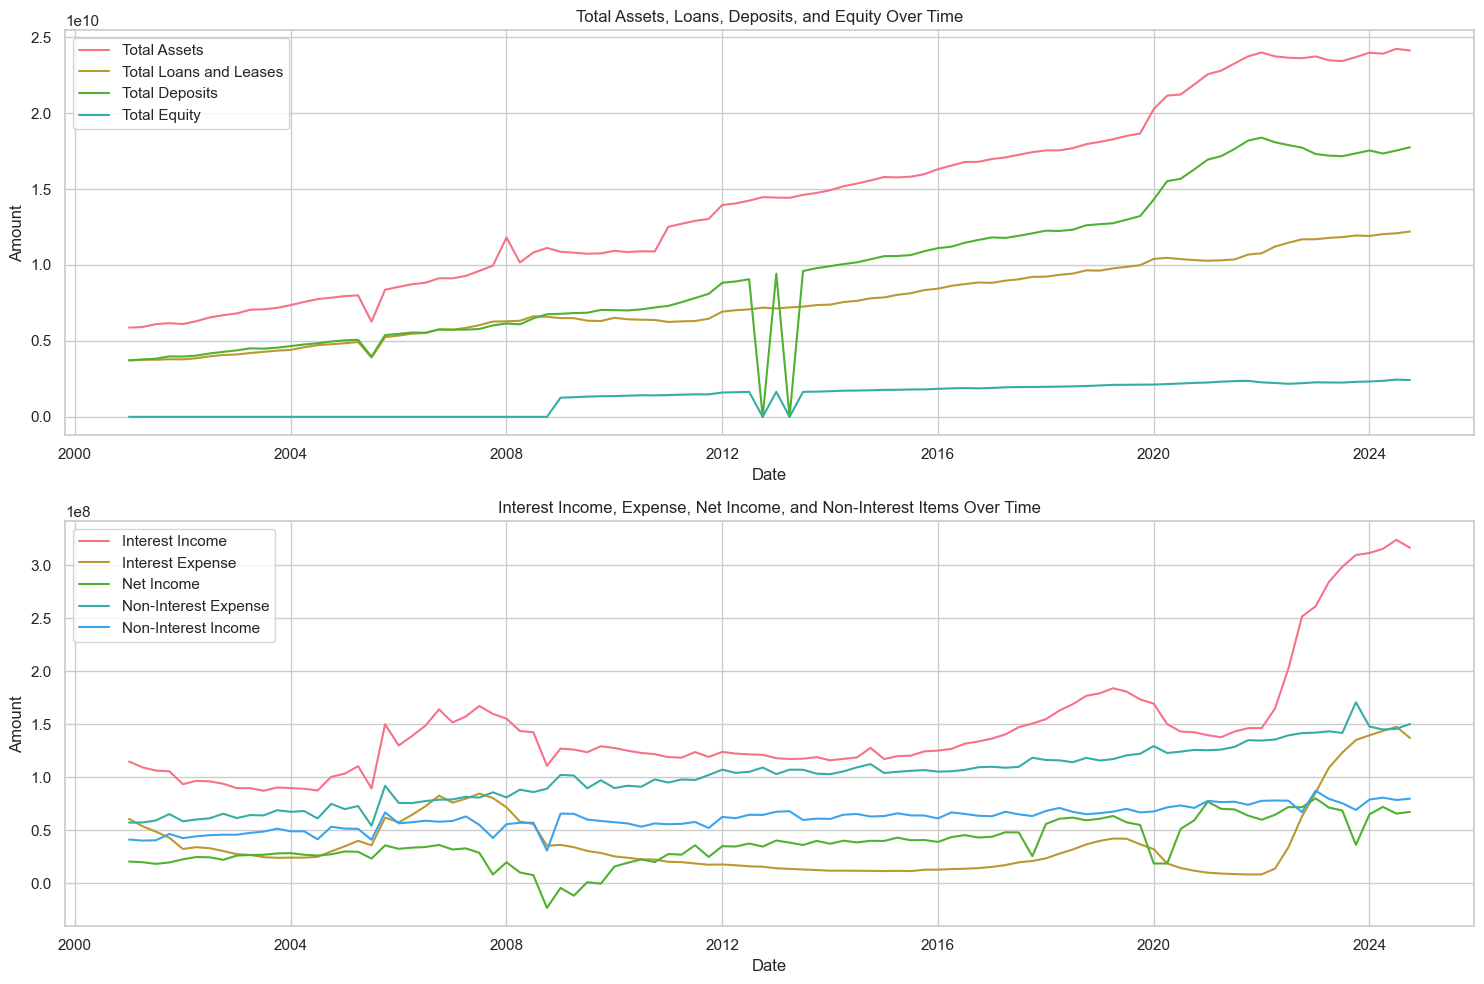

In [ ]:
# Show in two columns the following
# Chart 1: Total Assets, total loans and leases, total deposits, total equity
# Chart 2: Interest income, interest expense, net income, non-interest expense, non-interest income
import matplotlib.pyplot as plt
import seaborn as sns

selected_df_aggregated = selected_df.groupby('date').agg({
	'total_assets': 'sum',
	'total_loans_and_leases': 'sum',
	'total_deposits': 'sum',
	'total_equity': 'sum',
	'interest_income': 'sum',
	'interest_expense': 'sum',
	'net_income': 'sum',
	'non_interest_expense': 'sum',
	'non_interest_income': 'sum'
}).reset_index()

# Convert 'date' from period to timestamp for plotting
plot_df = selected_df_aggregated.copy()
if plot_df['date'].dtype.name.startswith('period'):
	plot_df['date'] = plot_df['date'].dt.to_timestamp()

# Set the style of seaborn
sns.set(style="whitegrid")
# Set the color palette
sns.set_palette("husl")
# Set the figure size
plt.figure(figsize=(15, 10))

# Create chart 1: 
# Total Assets, total loans and leases, total deposits, total equity
plt.subplot(2, 1, 1)
# Plot the data
sns.lineplot(data=plot_df, x='date', y='total_assets', label='Total Assets')
sns.lineplot(data=plot_df, x='date', y='total_loans_and_leases', label='Total Loans and Leases')
sns.lineplot(data=plot_df, x='date', y='total_deposits', label='Total Deposits')
sns.lineplot(data=plot_df, x='date', y='total_equity', label='Total Equity')
# Set the title and labels
plt.title('Total Assets, Loans, Deposits, and Equity Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')


# Create chart 2:
# Interest income, interest expense, net income, non-interest expense, non-interest income
plt.subplot(2, 1, 2)
# Plot the data
sns.lineplot(data=plot_df, x='date', y='interest_income', label='Interest Income')
sns.lineplot(data=plot_df, x='date', y='interest_expense', label='Interest Expense')
sns.lineplot(data=plot_df, x='date', y='net_income', label='Net Income')
sns.lineplot(data=plot_df, x='date', y='non_interest_expense', label='Non-Interest Expense')
sns.lineplot(data=plot_df, x='date', y='non_interest_income', label='Non-Interest Income')
# Set the title and labels
plt.title('Interest Income, Expense, Net Income, and Non-Interest Items Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()
